In [2]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

df = pd.read_csv(r"C:/Users/Lorenzo/Desktop/Training_py/retail_sales_cleaned.csv")
# Date in formato datetime
df['Date'] = pd.to_datetime(df['Date'])
# data come indice (per il resampling)
df = df.set_index('Date')

ts_monthly = df['Total Amount'].resample('ME').sum().to_frame(name='revenue')

print("ts_monthly:")
print(ts_monthly.head())

# 5. Ora il tuo test di stazionarietà funzionerà
def test_stationarity(timeseries):
    print("\n--- Risultati del Test di Dickey-Fuller ---")
    dftest = adfuller(timeseries['revenue'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    
    print(dfoutput)
    
    if dftest[1] <= 0.05:
        print("\nInterpretazione: La serie è STAZIONARIA (p-value <= 0.05)")
    else:
        print("\nInterpretazione: La serie NON è stazionaria. Serve differenziazione (d).")

test_stationarity(ts_monthly)



ts_monthly:
            revenue
Date               
2023-01-31    35450
2023-02-28    44060
2023-03-31    28990
2023-04-30    33870
2023-05-31    53150

--- Risultati del Test di Dickey-Fuller ---
Test Statistic                 -3.670209
p-value                         0.004552
#Lags Used                      0.000000
Number of Observations Used    12.000000
Critical Value (1%)            -4.137829
Critical Value (5%)            -3.154972
Critical Value (10%)           -2.714477
dtype: float64

Interpretazione: La serie è STAZIONARIA (p-value <= 0.05)


In [13]:
from statsmodels.tsa.arima.model import ARIMA

train = ts_monthly.iloc[:-3] #  ultimi 3 mesi per l'addestramento
test = ts_monthly.iloc[-3:] #  ultimi 3 mesi per il test


model = ARIMA(train, order=(1,1,1)) # 1 auto, 1 differenziazione, 1 media mobile
model_fit = model.fit()

print(model_fit.summary())




                               SARIMAX Results                                
Dep. Variable:                revenue   No. Observations:                   10
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -98.229
Date:                Sat, 21 Feb 2026   AIC                            202.459
Time:                        12:26:51   BIC                            203.050
Sample:                    01-31-2023   HQIC                           201.182
                         - 10-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2264      0.346      0.655      0.513      -0.451       0.904
ma.L1         -0.6882      0.408     -1.685      0.092      -1.489       0.112
sigma2      1.011e+08   1.84e-09    5.5e+16      0.0

Il termine AR(1) NON è significativo (p-value: 0.513)
Il termine MA(1) NON è significativo (p-value: 0.092)
Residui OK: Non c'è autocorrelazione (Ljung-Box p-value: 0.291)
Residui OK: Seguono una distribuzione normale (Jarque-Bera p-value: 0.698)
Anche provando altri modelli,il numero di osservazioni è troppo esiguo per raggiungere la significatività statistica e le previsioni potrebbero essere instabili.

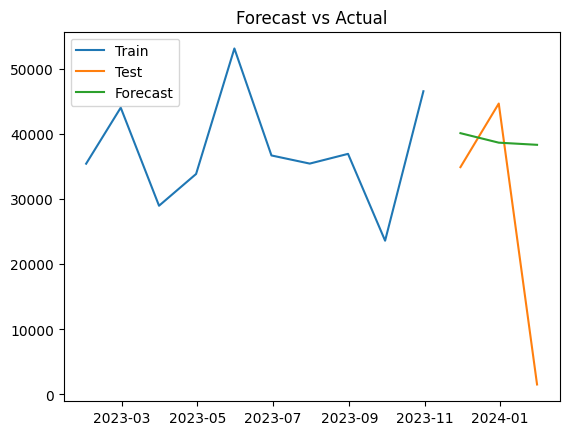

In [ ]:
import matplotlib.pyplot as plt
# grafico fit del modello
forecast = model_fit.forecast(steps=len(test))
forecast

plt.figure()
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast, label='Forecast')
plt.legend()
plt.title("Forecast vs Actual")
plt.show()

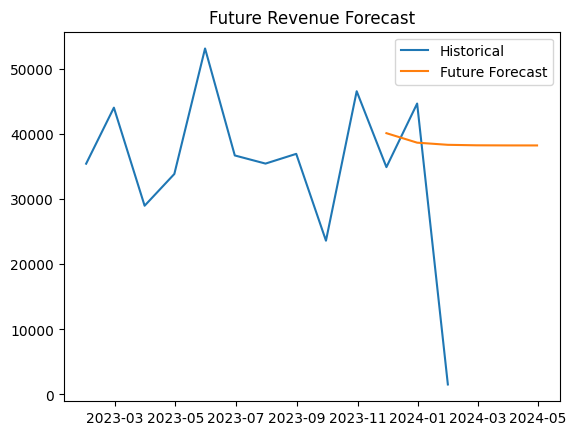

In [ ]:
# grafico previsioni future
future_forecast = model_fit.forecast(steps=6) # previsioni per i prossimi 6 mesi
future_forecast
plt.figure()
plt.plot(ts_monthly, label='Historical')
plt.plot(future_forecast, label='Future Forecast')
plt.legend()
plt.title("Future Revenue Forecast")
plt.show()

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test.values, forecast.values)
rmse = np.sqrt(mean_squared_error(test.values, forecast.values))

print('errore assoluto medio:', mae, 'radice errore quadratico medio', rmse)
mean_revenue = ts_monthly.mean().values[0]
mae_pct = mae / mean_revenue
print('errore percentuale:', mae_pct)

errore assoluto medio: 16015.869319155638 radice errore quadratico medio 21748.526529964678
errore percentuale: 0.45659276567768264


INSIGHT FORECASTS
- Il modello ARIMA mostra un errore medio pari a circa il 46% del fatturato mensile medio.
- Il modello cattura quindi il trend generale ma non fornisce previsioni puntuali affidabili.
- Necessari più dati storici, modelli più avanzati o variabili aggiuntive.